In [31]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.converters import circuit_to_instruction
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

#from qiskit import IBMQ, Aer

In [3]:
def rot_surf_code(n: int) -> QuantumCircuit:              #first ancilla = second last qubit = syndrome/parity measurement qubit, secondt ancilla = last qubit = magic state for T Gate
    qr = QuantumRegister(9*n+2, "q")
    cbit = ClassicalRegister(4,"c")
    qc = QuantumCircuit(qr,cbit)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

{'0000': 100}


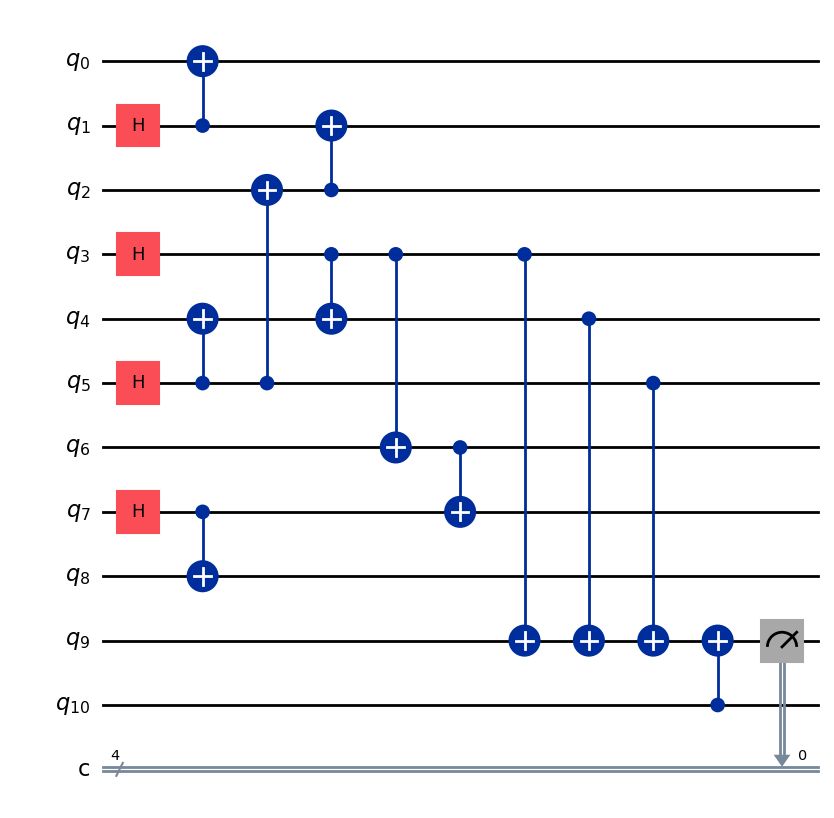

In [4]:
qc = rot_surf_code(1)         #Parity Measurement in Z-Basis --> Funktioniert!

#for i in range(9):
#    qc.h(i)

#qc.x(1)
#qc.x(4)
#qc.x(7)

qc.cx(3,9)
qc.cx(4,9)
qc.cx(5,9)

#qc.x(10)
qc.cx(10,9)

qc.measure(9,0)

sim = AerSimulator()
job = sim.run(qc, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)

qc.draw("mpl")

{'1': 69}


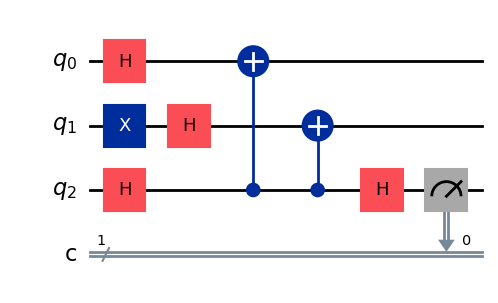

In [5]:
qr = QuantumRegister(3,"q")             #Parity Measurement in X-Basis --> Funktioniert!
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)

qc.h(0)
qc.x(1)
qc.h(1)


qc.h(2)

qc.cx(2,0)
qc.cx(2,1)

qc.h(2)

qc.measure(2,0)

sim = AerSimulator()
job = sim.run(qc, shots=69)
result = job.result()
counts = result.get_counts()
print(counts)
qc.draw("mpl")

{'0001': 100}


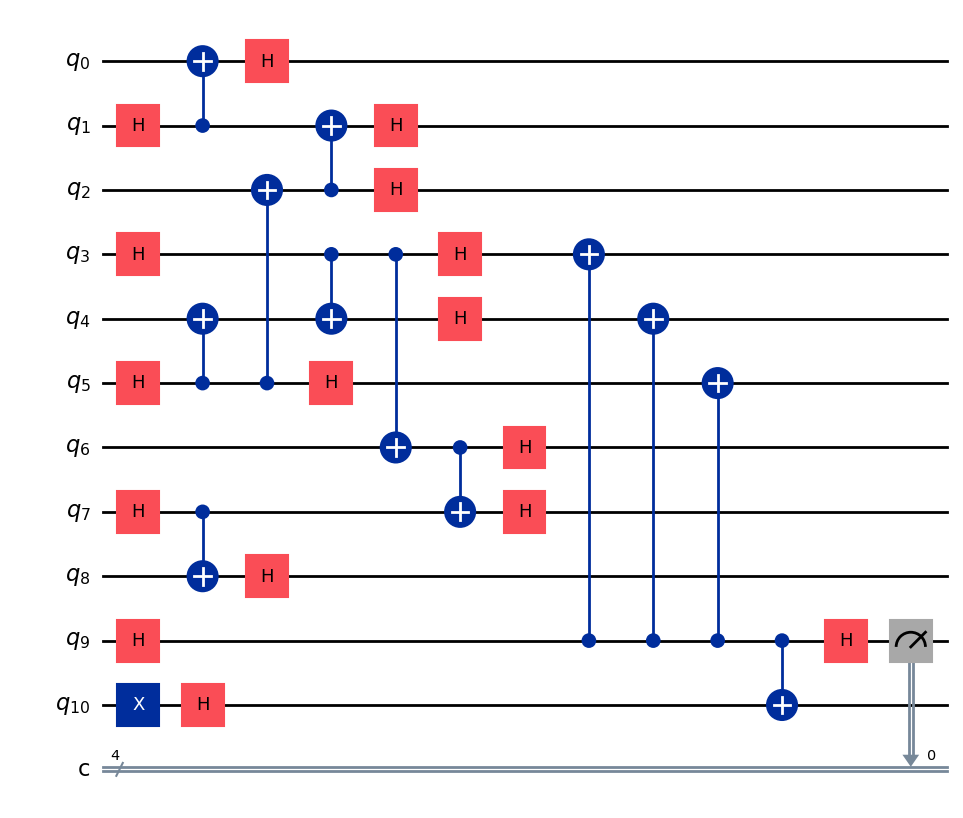

In [6]:
qc = rot_surf_code(1)         #Parity Measurement in X-Basis --> funktioniert!
#qc.z(3)
#qc.z(4)
#qc.z(5)

for i in range(9):
    qc.h(i)
                                #Initliasieren der Qubits für Parity Measruement

qc.x(10)
qc.h(10)

####################################################################

qc.h(9)

qc.cx(9,3)
qc.cx(9,4)
qc.cx(9,5)

qc.cx(9,10)

qc.h(9)

qc.measure(9,0)

sim = AerSimulator()
job = sim.run(qc, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)

qc.draw("mpl")

{'1': 69}


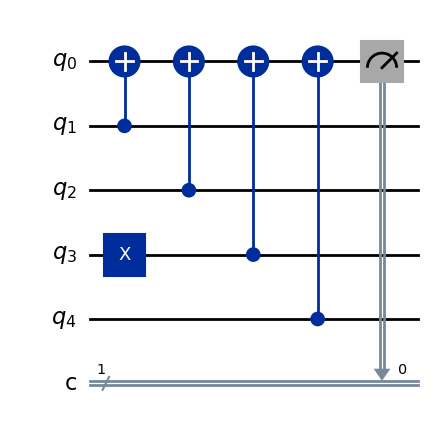

In [7]:
qr = QuantumRegister(5,"q")             #Parity Measurement in X-Basis --> Funktioniert!
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)


qc.x(3)

for i in range(4):
    qc.cx(1+i,0)

qc.measure(0,0)

sim = AerSimulator()
job = sim.run(qc, shots=69)
result = job.result()
counts = result.get_counts()
print(counts)
qc.draw("mpl")

{'1': 38, '0': 31}


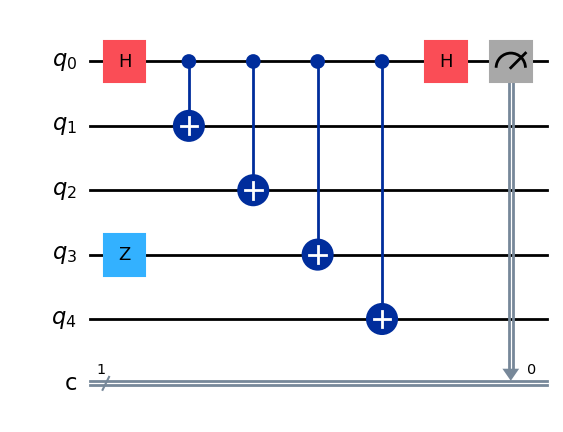

In [8]:
qr = QuantumRegister(5,"q")             #Parity Measurement in X-Basis --> Funktioniert!
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)


qc.z(3)

qc.h(0)
for i in range(4):
    qc.cx(0,1+i)
qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
job = sim.run(qc, shots=69)
result = job.result()
counts = result.get_counts()
print(counts)
qc.draw("mpl")

In [109]:
def X_L(circuit: QuantumCircuit, hadamard = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        circuit.x(9*n+3)
        circuit.x(9*n+4)
        circuit.x(9*n+5)
    else:
        circuit.x(9*n+1)
        circuit.x(9*n+4)
        circuit.x(9*n+7)
    return circuit

def Z_L(circuit: QuantumCircuit, hadamard = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        circuit.z(9*n+1)
        circuit.z(9*n+4)
        circuit.z(9*n+7)
    else:
        circuit.z(9*n+3)
        circuit.z(9*n+4)
        circuit.z(9*n+5)
    return circuit

def Hadamard(circuit: QuantumCircuit, pos=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    for i in range(9):
        circuit.h(9*pos+i)
    return circuit

def S_L(circuit: QuantumCircuit, hadamard = False, pos=0):
    for i in range(9):
        circuit.s(9*pos+i)
    qc = Z_L(circuit, hadamard=hadamard, n = pos)
    return qc

def adjoint_S_L(circuit: QuantumCircuit, hadamard = False, pos=0):
    for i in range(9):
        circuit.sdg(9*pos+i)
    qc = Z_L(circuit, hadamard=hadamard, n = pos)
    return qc

def Z_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 2
    if hadamard:
        qc.cx(1+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(7+9*pos,ancilla)
    else:
        qc.cx(3+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
    return qc

def X_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 2
    #qc.h(ancilla)
    if hadamard:
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,5+9*pos)
    else:
        qc.cx(ancilla,1+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,7+9*pos)
    #qc.h(ancilla)
    return qc

def reset_logical_qubit(qc: QuantumCircuit, pos = 0):
    for i in range(9):
        qc.reset(9*pos+i)
    i = pos
    qc.h(9*i+1)
    qc.h(9*i+3)
    qc.h(9*i+5)
    qc.h(9*i+7)

    qc.cx(9*i+1, 9*i)
    qc.cx(9*i+5, 9*i+4)
    qc.cx(9*i+7, 9*i+8)

    qc.cx(9*i+5, 9*i+2)

    qc.cx(9*i+3, 9*i+4)
    qc.cx(9*i+2, 9*i+1)

    qc.cx(9*i+3,9*i+6)

    qc.cx(9*i+6,9*i+7)
    return qc
    
def T_L(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    magic = qc.num_qubits - 1
    ancilla = qc.num_qubits - 2
    qc.reset(magic)
    qc.reset(ancilla)
    
    qc.h(magic)
    qc.t(magic)                 #Initliaisierung vom Magic State

    qc = Z_parity(qc, hadamard=False, pos = pos)
    qc.cx(magic, ancilla)

    qc.measure(ancilla,0)
    with qc.if_test((0,1)):
        qc = S_L(qc,hadamard=hadamard,pos=pos)
    
    qc.h(magic)
    qc.measure(magic,0)
    with qc.if_test((0,1)):
        qc = Z_L(qc, hadamard=hadamard, n=pos)
    qc.reset(ancilla)
    return qc

def adjoint_T_L(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    magic = qc.num_qubits - 1
    ancilla = qc.num_qubits - 2
    qc.reset(magic)
    qc.reset(ancilla)

    qc.h(magic)
    qc.tdg(magic)                 #Initliaisierung vom Magic State

    qc = Z_parity(qc, hadamard=hadamard, pos = pos)
    qc.cx(magic, ancilla)

    qc.measure(ancilla,0)
    with qc.if_test((0,1)):
        qc = adjoint_S_L(qc,hadamard=hadamard,pos=pos)
    
    qc.h(magic)
    qc.measure(magic,0)
    with qc.if_test((0,1)):
        qc = Z_L(qc, hadamard=hadamard, n=pos)  
    qc.reset(ancilla)
    return qc

def CNOT(circuit:QuantumCircuit, hadamard = "00", control = 0):               #CNOT mit berücksichtigung der Rotation durch H-Gate
    if control == 0:
        if hadamard == "10":
            circuit.cx(control_qubit=0,target_qubit=9+6)
            circuit.cx(control_qubit=1,target_qubit=9+3)
            circuit.cx(control_qubit=2,target_qubit=9+0)
            circuit.cx(control_qubit=3,target_qubit=9+7)
            circuit.cx(control_qubit=4,target_qubit=9+4)
            circuit.cx(control_qubit=5,target_qubit=9+1)
            circuit.cx(control_qubit=6,target_qubit=9+8)
            circuit.cx(control_qubit=7,target_qubit=9+5)
            circuit.cx(control_qubit=8,target_qubit=9+2)
        elif hadamard == "01":
            circuit.cx(control_qubit=0,target_qubit=9+2)
            circuit.cx(control_qubit=1,target_qubit=9+5)
            circuit.cx(control_qubit=2,target_qubit=9+8)
            circuit.cx(control_qubit=3,target_qubit=9+1)
            circuit.cx(control_qubit=4,target_qubit=9+4)
            circuit.cx(control_qubit=5,target_qubit=9+7)
            circuit.cx(control_qubit=6,target_qubit=9+0)
            circuit.cx(control_qubit=7,target_qubit=9+3)
            circuit.cx(control_qubit=8,target_qubit=9+6)
        else:
            for i in range(9):
                circuit.cx(control_qubit=i,target_qubit=9+i)
    elif control == 1:
        if hadamard == "01":
            circuit.cx(control_qubit=9+0,target_qubit=6)
            circuit.cx(control_qubit=9+1,target_qubit=3)
            circuit.cx(control_qubit=9+2,target_qubit=0)
            circuit.cx(control_qubit=9+3,target_qubit=7)
            circuit.cx(control_qubit=9+4,target_qubit=4)
            circuit.cx(control_qubit=9+5,target_qubit=1)
            circuit.cx(control_qubit=9+6,target_qubit=8)
            circuit.cx(control_qubit=9+7,target_qubit=5)
            circuit.cx(control_qubit=9+8,target_qubit=2)
        elif hadamard == "10":
            circuit.cx(control_qubit=9+0,target_qubit=2)
            circuit.cx(control_qubit=9+1,target_qubit=5)
            circuit.cx(control_qubit=9+2,target_qubit=8)
            circuit.cx(control_qubit=9+3,target_qubit=1)
            circuit.cx(control_qubit=9+4,target_qubit=4)
            circuit.cx(control_qubit=9+5,target_qubit=7)
            circuit.cx(control_qubit=9+6,target_qubit=0)
            circuit.cx(control_qubit=9+7,target_qubit=3)
            circuit.cx(control_qubit=9+8,target_qubit=6)
        else: 
            for i in range(9):
                circuit.cx(control_qubit=9+i,target_qubit=i)
    return circuit

def control_S_L(circuit: QuantumCircuit, hadamard = "00", control = 0, target = 1):
    qc = circuit
    qc = T_L(qc, hadamard=True, pos=control)
    qc = T_L(qc, hadamard=False, pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    qc = adjoint_T_L(qc,hadamard=False,pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    return qc

def control_Z_L(circuit: QuantumCircuit, control = 0, target = 1):
    qc = circuit
    qc = Hadamard(qc, pos = target)
    qc = CNOT(qc, control = control)            #aufgrund des H eine Zeile drüber, geht das normale CNOT
    qc = Hadamard(qc, pos = target)
    return qc

def control_Z_L_test(circuit: QuantumCircuit, hadamard = "00", control = 0, target = 1):
    qc = circuit
    qc = S_L(qc, hadamard=False, pos=control)
    qc = S_L(qc, hadamard=True, pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    qc = adjoint_S_L(qc,hadamard=True,pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    return qc

def stabilize(circuit: QuantumCircuit, hadamard = False, pos = 0):                     #misst alle stabilizer, speichert den Fehler und korrigiert dementsprechend
    qc = circuit
    ancilla = qc.num_qubits - 2

    if hadamard:
        #X2 X5 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,2+9*pos)
        qc.cx(ancilla,5+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,0)
        with qc.if_test((0,1)):
            qc.z(2+9*pos)

        #X3 X6 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,6+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,0)
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
        
        #X4 X5 X7 X8 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,5+9*pos)
        qc.cx(ancilla,7+9*pos)
        qc.cx(ancilla,8+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,1)

        #X0 X1 X3 X4 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,0+9*pos)
        qc.cx(ancilla,1+9*pos)
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,2)

        with qc.if_test((2,1)) and qc.if_test((1,1)):
            qc.z(4+9*pos)

        with qc.if_test((1,1)) and qc.if_test((2,0)):
            qc.z(7+9*pos)

        with qc.if_test((2,1)) and qc.if_test((1,0)):
            qc.z(1+9*pos)

    ###########################################################################################################

        #Z0 Z1 Stabilizer:
        qc.reset(ancilla)
        qc.cx(0+9*pos,ancilla)
        qc.cx(1+9*pos,ancilla)
        qc.measure(ancilla,0)
        with qc.if_test((0,1)):
            qc.x(0+9*pos)

        #Z7 Z8 Stabilizer:
        qc.reset(ancilla)
        qc.cx(7+9*pos,ancilla)
        qc.cx(8+9*pos,ancilla)
        qc.measure(ancilla,0)
        with qc.if_test((0,1)):
            qc.x(7+9*pos)

        #Z1 Z2 Z4 Z5 Stabilizer:
        qc.reset(ancilla)
        qc.cx(1+9*pos,ancilla)
        qc.cx(2+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
        qc.measure(ancilla,1)
    
        #Z3 Z4 Z6 Z7 Stabilizer:
        qc.reset(ancilla)
        qc.cx(3+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(6+9*pos,ancilla)
        qc.cx(7+9*pos,ancilla)
        qc.measure(ancilla,2)
        
        with qc.if_test((2,1)) and qc.if_test((1,1)):
            qc.x(4+9*pos)

        with qc.if_test((1,1)) and qc.if_test((2,0)):
            qc.x(2+9*pos)

        with qc.if_test((2,1)) and qc.if_test((1,0)):
            qc.x(3+9*pos)
    else:
        #X0 X1 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,0+9*pos)
        qc.cx(ancilla,1+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,0)
        
        #X1 X2 X4 X5 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,1+9*pos)
        qc.cx(ancilla,2+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,5+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,1)

        #X3 X4 X6 X7 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,6+9*pos)
        qc.cx(ancilla,7+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,2)

        #X7 X8 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,7+9*pos)
        qc.cx(ancilla,8+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,3)

        with qc.if_test((0,1)) and qc.if_test((1,0)) and qc.if_test((2,0)) and qc.if_test((3,0)):
            qc.z(1+9*pos)
            qc.z(3+9*pos)
            qc.z(4+9*pos)

        with qc.if_test((0,0)) and qc.if_test((1,0)) and qc.if_test((2,0)) and qc.if_test((3,1)):
            qc.z(4+9*pos)
            qc.z(5+9*pos)
            qc.z(7+9*pos)

        with qc.if_test((0,0)) and qc.if_test((1,1)) and qc.if_test((2,0)) and qc.if_test((3,0)):
            qc.z(4+9*pos)
            qc.z(5+9*pos)
            qc.z(7+9*pos)

    ###########################################################################################################

        #Z3 Z6 Stabilizer:
        qc.reset(ancilla)
        qc.cx(3+9*pos,ancilla)
        qc.cx(6+9*pos,ancilla)
        qc.measure(ancilla,0)
        with qc.if_test((0,1)):
            qc.x(6+9*pos)
        
        #Z2 Z5 Stabilizer:
        qc.reset(ancilla)
        qc.cx(2+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
        qc.measure(ancilla,0)
        with qc.if_test((0,1)):
            qc.x(2+9*pos)

        #Z0 Z1 Z3 Z4 Stabilizer:
        qc.reset(ancilla)
        qc.cx(0+9*pos,ancilla)
        qc.cx(1+9*pos,ancilla)
        qc.cx(3+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.measure(ancilla,1)
    
        #Z4 Z5 Z7 Z8 Stabilizer:
        qc.reset(ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
        qc.cx(7+9*pos,ancilla)
        qc.cx(8+9*pos,ancilla)
        qc.measure(ancilla,2)
        
        with qc.if_test((2,1)) and qc.if_test((1,1)):
            qc.x(4+9*pos)

        with qc.if_test((1,1)) and qc.if_test((2,0)):
            qc.x(1+9*pos)

        with qc.if_test((2,1)) and qc.if_test((1,0)):
            qc.x(7+9*pos)
    
    qc.reset(ancilla)
    return qc

In [10]:
qc = rot_surf_code(1)               #Logical (adjoint) T scheint NICHT gescheit zu funktionieren!

ancilla = qc.num_qubits - 2

qc = Hadamard(qc,0)

for i in range(4):
    qc = T_L(qc, False, 0)

# for i in range(4):
#     qc = adjoint_T_L(qc, True, 0)

#qc = Z_L(qc, True, 0)

qc = Hadamard(qc,0)

#qc.reset(ancilla)

qc = Z_parity(qc,False,0)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1...: ", counts)

Wir wollen 1...:  {'1000': 45, '1001': 54}


In [11]:
qc = rot_surf_code(1)             #Stabilizer funktioniert, aber rotated Fall fehlt noch!

qc.x(3)

qc = stabilize(qc)

#qc.x(1)
#qc.x(4)
#qc.x(7)

qc.cx(3,9)
qc.cx(4,9)
qc.cx(5,9)

qc.cx(10,9)

qc.measure(9,0)

sim = AerSimulator()
job = sim.run(qc, shots=69)
result = job.result()
counts = result.get_counts()
print(counts)

#qc.draw("mpl")

{'0000': 69}


In [50]:
depolarizing_prob = 0.1
dep_error = depolarizing_error(depolarizing_prob, 1)
dep_error_2q = depolarizing_error(depolarizing_prob, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","t","tdg","sdg"])  # Apply to single-qubit gates
noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

In [62]:
#Implementation von iQPE für 2 Iterationen mit Theta=90°

qc = rot_surf_code(2)

ancilla = qc.num_qubits - 2

qc = X_L(qc, n = 1)

qc = stabilize(qc,False,1)

qc = Hadamard(qc, pos=0)

qc = stabilize(qc,True,0)

# qc = control_S_L(qc,"00")
# qc = control_S_L(qc,"00")
qc = control_Z_L(qc)
qc = Hadamard(qc ,pos=0)

qc.reset(ancilla)

qc = Z_parity(qc,hadamard = False,pos=0)

qc.measure(ancilla,3)

qc = reset_logical_qubit(qc, pos = 0)
qc = reset_logical_qubit(qc, pos = 1)
qc.reset(ancilla)
qc.reset(ancilla+1)

qc = X_L(qc, n = 1)
qc = Hadamard(qc, 0)

qc = control_S_L(qc,"00")
qc = adjoint_S_L(qc, hadamard=True, pos = 0)
qc = Hadamard(qc, 0)

qc.reset(ancilla)
qc = Z_parity(qc, pos = 0)

qc.measure(ancilla,2)

sim = AerSimulator()
job = sim.run(qc, noise_model = noise_model, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 10_ _: ",counts)

Wir erwarten 10_ _:  {'0100': 5, '0111': 8, '0011': 6, '1011': 7, '0001': 9, '1111': 7, '1010': 6, '0010': 3, '0000': 5, '0101': 5, '1001': 4, '1100': 6, '1000': 6, '0110': 9, '1101': 7, '1110': 6}


In [112]:
#Implementation von iQPE für 2 Iterationen mit Theta=90°  : Erste Iteration

qc = rot_surf_code(2)

ancilla = qc.num_qubits - 2

qc = X_L(qc, n = 1)

#qc = stabilize(qc,False,1)

qc = Hadamard(qc, pos=0)

#qc = stabilize(qc,True,0)

# qc = control_S_L(qc,"00")
# qc = control_S_L(qc,"00")
qc = control_Z_L(qc,control=0,target=1)

#qc = stabilize(qc,True,0)

qc = Hadamard(qc ,pos=0)

qc.x(5)

#qc = stabilize(qc,False,0)

qc.reset(ancilla)

qc = Z_parity(qc,hadamard = False,pos=0)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 1 _ _ _: ",counts)

Wir erwarten 1 _ _ _:  {'1000': 99}


In [49]:
#Implementation von iQPE für 2 Iterationen mit Theta=90°  : Zweite Iteration

qc = rot_surf_code(2)

ancilla = qc.num_qubits - 2

qc = X_L(qc, n = 1)
qc = Hadamard(qc, 0)

qc = control_S_L(qc,"00",control = 0, target = 1)
qc = adjoint_S_L(qc, hadamard=True, pos = 0)
qc = Hadamard(qc, 0)

qc.reset(ancilla)
qc = Z_parity(qc, pos = 0)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, noise_model = noise_model,shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 0 _ _ _: ",counts)

Wir erwarten 0 _ _ _:  {'0001': 20, '0000': 27, '1001': 22, '1000': 30}


In [46]:
#Implementation von iQPE für 2 Iterationen mit Theta=270°

qc = rot_surf_code(2)

ancilla = qc.num_qubits - 2

qc = X_L(qc, n = 1)
qc = Hadamard(qc, pos=0)
qc = control_Z_L(qc)
qc = Hadamard(qc ,pos=0)

qc.reset(ancilla)

qc = Z_parity(qc,hadamard = False,pos=0)

qc.measure(ancilla,3)


qc = reset_logical_qubit(qc, pos = 0)
qc = reset_logical_qubit(qc, pos = 1)
qc.reset(ancilla)
qc.reset(ancilla+1)

qc = X_L(qc, n = 1)
qc = Hadamard(qc, 0)

qc = control_Z_L(qc,"00")
qc = control_S_L(qc,"00")
qc = adjoint_S_L(qc, hadamard=True, pos = 0)
qc = Hadamard(qc, 0)

qc.reset(ancilla)
qc = Z_parity(qc, pos = 0)

qc.measure(ancilla,2)

sim = AerSimulator()
job = sim.run(qc, noise_model=noise_model, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 11 _ _: ",counts)

Wir erwarten 11 _ _:  {'0100': 8, '0000': 17, '0101': 11, '0001': 15, '1000': 13, '1001': 12, '1100': 13, '1101': 10}


{'1000': 99}


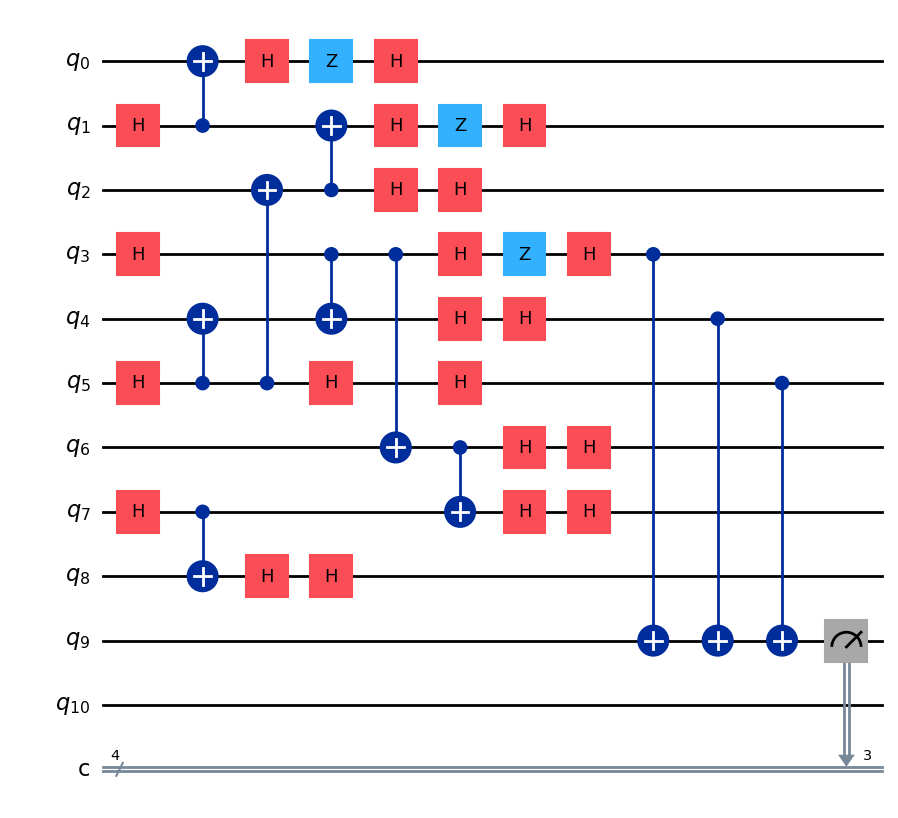

In [16]:
qc = rot_surf_code(1)

ancilla = qc.num_qubits - 2

#qc = X_L(qc, 0)

qc = Hadamard(qc)

qc.z(0)
qc.z(1)
qc.z(3)

qc = Hadamard(qc)

qc = Z_parity(qc, 0)

qc.measure(ancilla,3)

im = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

In [17]:
qc = rot_surf_code(1)                           #Logisches S scheint zu funktionieren!

ancilla = qc.num_qubits - 2

qc = Hadamard(qc, 0)

qc = S_L(qc, hadamard=True, pos=0)

qc = S_L(qc, hadamard=True, pos=0)

#qc = Z_L(qc, False, 0)

qc = Hadamard(qc, 0)
# qc = X_L(qc,1)

qc = Z_parity(qc, False, 0)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _:", counts)

Wir wollen 1 _ _ _: {'1000': 99}


Wir erwarten 1000, aber das bekommen wir:  {'1000': 99}


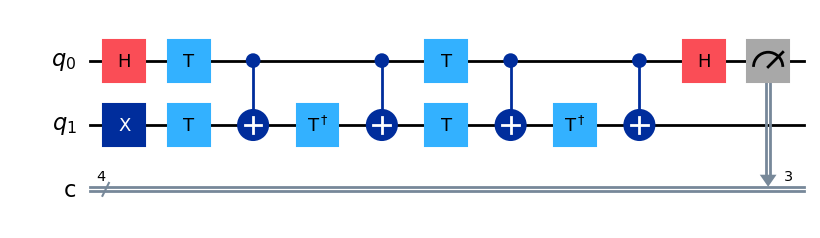

In [18]:
qr = QuantumRegister(2,"q")                     #Klassische Version vom Controlled S funktioniert!!!
cbit = ClassicalRegister(4,"c")
qc = QuantumCircuit(qr,cbit)

qc.x(1)

qc.h(0)

for i in range(2):
    qc.t(0)
    qc.t(1)
    qc.cx(0,1)
    qc.tdg(1)
    qc.cx(0,1)

qc.h(0)

qc.measure(0,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 1000, aber das bekommen wir: ",counts)

qc.draw("mpl")

Wir erwarten 10, aber das bekommen wir:  {'10': 99}


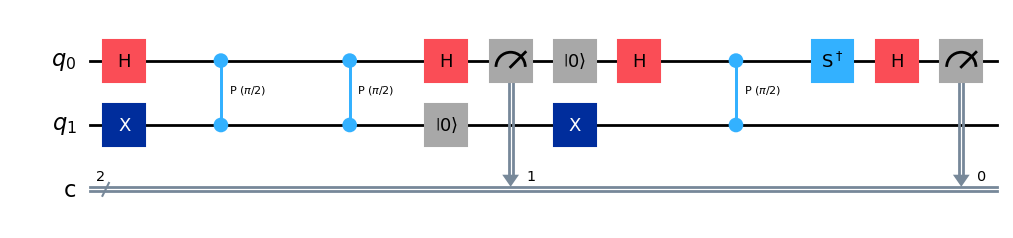

In [19]:
qr = QuantumRegister(2,"q")                     #Klassische Version vom Controlled S funktioniert!!!
cbit = ClassicalRegister(2,"c")
qc = QuantumCircuit(qr,cbit)

qc.x(1)

qc.h(0)

qc.cp(np.pi/2,0,1)
qc.cp(np.pi/2,0,1)

qc.h(0)

qc.measure(0,1)

qc.reset(0)
qc.reset(1)

qc.x(1)
qc.h(0)
qc.cp(np.pi/2,0,1)
qc.sdg(0)
qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 10, aber das bekommen wir: ",counts)

qc.draw("mpl")

{'11': 99}


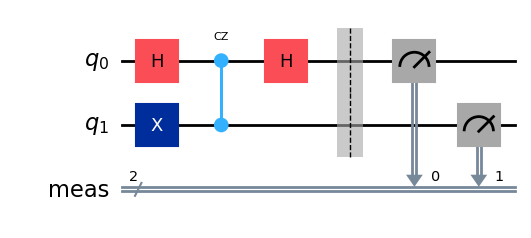

In [20]:
qr = QuantumRegister(2,"q")                     #Klassischer Circuit vom Code drunter zur Veranschaulichung!
cbit = ClassicalRegister(4,"c")
qc = QuantumCircuit(qr)

qc.x(1)

qc.h(0)

qc.cz(0,1,"CZ")

qc.h(0)

qc.measure_all()

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

In [21]:
qc = rot_surf_code(2)               #Logische Version vom Controlled S funktioniert net gescheid :/

ancilla = qc.num_qubits - 2

qc = Hadamard(qc,0)

qc = X_L(qc, False, n = 1)

# qc = control_S_L(qc, hadamard="10", control = 1, target = 0)

# qc = control_S_L(qc, hadamard="10", control = 1, target = 0)
qc = control_Z_L_test(qc, "00", control=1 , target=0)

qc = Hadamard(qc,0)

qc = Z_parity(qc, False, 0)                             #Der zweite logische Qubit wird richtig gemessen (Ohne Hadamards)
qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'1000': 99}


In [22]:
qc = rot_surf_code(2)                   #CNOT und parity Measurements sind H sensibel, Z_L/X_L nicht!

ancilla  = qc.num_qubits - 2

magic = ancilla + 1

qc = Hadamard(qc,0)

qc = CNOT(qc, "10", control = 0)

qc = CNOT(qc, "10", control = 1)

qc = X_L(qc,True,0)

qc.cx(magic,ancilla)

qc = Z_parity(qc,True,0)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'1000': 99}


In [23]:
qc = rot_surf_code(2)                  

ancilla  = qc.num_qubits - 2

magic = ancilla + 1

qc = Hadamard(qc,1)

qc = X_L(qc,0)

qc = CNOT(qc, "01", control = 0)

#qc = Hadamard(qc,0)

qc.h(ancilla)
qc = X_parity(qc,True,1)
qc.h(ancilla)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'0000': 99}


In [24]:
qc = rot_surf_code(2)                  

ancilla  = qc.num_qubits - 2

magic = ancilla + 1

qc = Hadamard(qc,1)

qc = X_L(qc,0)

qc = CNOT(qc, "01", control = 1)
qc = Z_L(qc,True,0)
qc = CNOT(qc, "01", control = 1)

qc = Hadamard(qc,1)

qc = Z_parity(qc,False,1)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'1000': 99}
